In [9]:
import re
import pandas as pd
import pickle
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
classified_logs = pd.read_csv("classified_logs.csv")

with open("windowed_sequences (3).pkl", "rb") as f:
    windowed_sequences = pickle.load(f)

log_sequence_matrix = joblib.load("log_sequence_matrix.joblib")  # vectorized matrix

print(f"✅ Loaded {len(windowed_sequences)} windowed sequences")
print(f"✅ Vectorized matrix shape: {log_sequence_matrix.shape}")
print(f"📄 Classified logs columns: {classified_logs.columns.tolist()}")

with open("y_labels (2).pkl", "rb") as f:
    y_labels = pickle.load(f)

print(f"✅ Loaded {len(y_labels)} y labels")

✅ Loaded 56480 windowed sequences
✅ Vectorized matrix shape: (56480, 100)
📄 Classified logs columns: ['LineId', 'Time', 'Level', 'Content', 'EventId', 'EventTemplate']
✅ Loaded 56480 y labels


In [12]:
#Regex Models

# Define anomaly patterns
anomaly_patterns = [r"E10", r"E11", r"E12"]

# Function to detect anomalies in a sequence of events
def regex_detect(sequence):
    seq_str = " ".join(sequence)  # join all events in window
    return 1 if any(re.search(pattern, seq_str) for pattern in anomaly_patterns) else 0

# Apply to all windows
regex_labels = [regex_detect(seq) for seq in windowed_sequences]

# Calculate metrics
regex_metrics = {
    "Accuracy": accuracy_score(y_labels, regex_labels),
    "Precision": precision_score(y_labels, regex_labels, zero_division=0),
    "Recall": recall_score(y_labels, regex_labels, zero_division=0),
    "F1": f1_score(y_labels, regex_labels, zero_division=0)
}

print("Regex Model Metrics:")
for metric, value in regex_metrics.items():
    print(f"{metric}: {value:.4f}")

# Save for later comparison
import joblib
joblib.dump(regex_labels, "regex_labels.joblib")

Regex Model Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000


['regex_labels.joblib']

Here the values are all 1 because the y_labels.pkl was generated using same rule as regex baseline

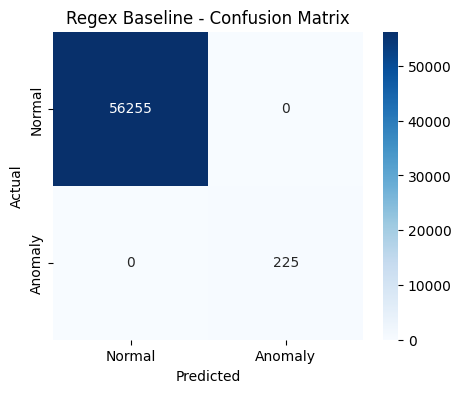


 Example Detected Anomalies (Regex):
1. E17 | E17 | E10
2. E17 | E10 | E11
3. E10 | E11 | E12
4. E11 | E12 | E25
5. E12 | E25 | E25


In [10]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_labels, regex_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Regex Baseline - Confusion Matrix")
plt.show()

# Example anomalies
anomaly_examples = [seq for seq, label in zip(windowed_sequences, regex_labels) if label == 1][:5]
print("\n Example Detected Anomalies (Regex):")
for i, seq in enumerate(anomaly_examples, 1):
    print(f"{i}. {' | '.join(seq)}")

In [28]:
# compare regex with unsupervised

iso_labels = joblib.load("isolation_forest.joblib")
lof_labels = joblib.load("local_outlier_factor.joblib")
ocsvm_labels = joblib.load("one_class_svm.joblib")
elliptic_labels = joblib.load("elliptic_envelope.joblib")
dbscan_labels = joblib.load("dbscan (2).joblib")

ml_results = {
    "RegexBaseline": regex_labels,
    "IsolationForest": iso_labels,
    "LOF": lof_labels,
    "OneClassSVM": ocsvm_labels,
    "EllipticEnvelope": elliptic_labels,
    "DBSCAN": dbscan_labels
}

In [29]:
import pandas as pd

# Load the file with ground truth labels
labels_df = pd.read_csv("unsupervised_labels_with_majority.csv")

# Ground truth
y_true = labels_df["Final_Label"].values

# Now you can safely run your metrics calculation
metrics = {}
for model_name, preds in ml_results.items():
    metrics[model_name] = {
        "Accuracy": accuracy_score(y_true, preds),
        "Precision": precision_score(y_true, preds, zero_division=0),
        "Recall": recall_score(y_true, preds, zero_division=0),
        "F1": f1_score(y_true, preds, zero_division=0)
    }

comparison_df = pd.DataFrame(metrics).T
print(comparison_df)
comparison_df.to_csv("model_comparison.csv", index=True)

                  Accuracy  Precision    Recall        F1
RegexBaseline     0.993626   0.200000  0.200000  0.200000
IsolationForest   0.789926   0.018610  1.000000  0.036541
LOF               0.991926   0.299130  0.764444  0.430000
OneClassSVM       0.751647   0.010567  0.662222  0.020803
EllipticEnvelope  0.898637   0.009279  0.231111  0.017842
DBSCAN            0.997468   0.756250  0.537778  0.628571


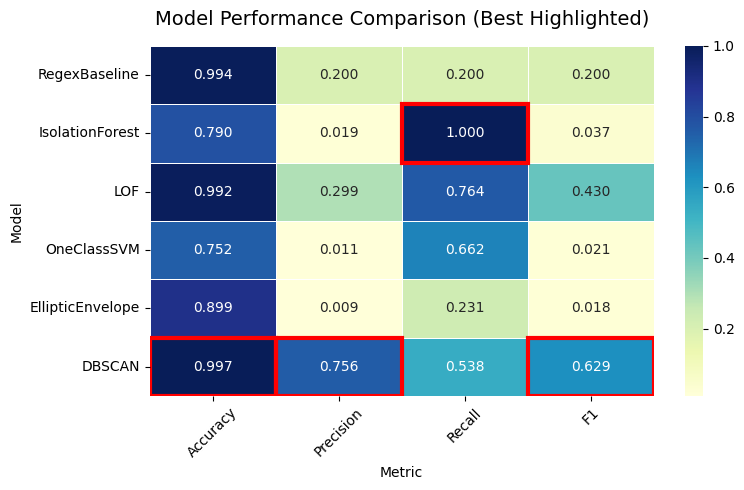

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Your metrics table as a DataFrame
data = {
    "Accuracy": {
        "RegexBaseline": 0.993626,
        "IsolationForest": 0.789926,
        "LOF": 0.991926,
        "OneClassSVM": 0.751647,
        "EllipticEnvelope": 0.898637,
        "DBSCAN": 0.997468
    },
    "Precision": {
        "RegexBaseline": 0.200000,
        "IsolationForest": 0.018610,
        "LOF": 0.299130,
        "OneClassSVM": 0.010567,
        "EllipticEnvelope": 0.009279,
        "DBSCAN": 0.756250
    },
    "Recall": {
        "RegexBaseline": 0.200000,
        "IsolationForest": 1.000000,
        "LOF": 0.764444,
        "OneClassSVM": 0.662222,
        "EllipticEnvelope": 0.231111,
        "DBSCAN": 0.537778
    },
    "F1": {
        "RegexBaseline": 0.200000,
        "IsolationForest": 0.036541,
        "LOF": 0.430000,
        "OneClassSVM": 0.020803,
        "EllipticEnvelope": 0.017842,
        "DBSCAN": 0.628571
    }
}

df = pd.DataFrame(data)

# Mask to highlight the max value per column
highlight_mask = df.eq(df.max())

# Create base heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".3f", cbar=True, linewidths=.5)

# Overlay red boxes on max values
for y in range(df.shape[0]):
    for x in range(df.shape[1]):
        if highlight_mask.iloc[y, x]:
            plt.gca().add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=3))

plt.title("Model Performance Comparison (Best Highlighted)", fontsize=14, pad=15)
plt.ylabel("Model")
plt.xlabel("Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
